In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pandas.plotting import scatter_matrix
import seaborn as sns

# Result from notebook 01
import CategoricalPrep as cp

# Auxilliary functions
from ExploreData import sort_mean, value_counter, index_by_key
from TransformData import \
    price_transform, rate_transform, split_column_values, date_transform


%matplotlib inline
sns.set_theme()

In [2]:
df_listings = pd.read_csv('./data/listings.csv')

Up to now the listings data has been explored thoroughly. These learnings are stored in the functions below.

1. Some columns don't seem to be relevant
2. And some columns are easier to handle when transformed into a different type or form

In [3]:
# Drop Columns without information
listings_drop_col = cp.drop_columns_analyze(df_listings)
# Transform categorical columns and make information accessable
listings_drop_trans = cp.transform_columns(listings_drop_col)

In [4]:
# Show all columns
listings_drop_trans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 124 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    id                                    int64  
 1    name                                  object 
 2    summary                               object 
 3    space                                 object 
 4    description                           object 
 5    neighborhood_overview                 object 
 6    notes                                 object 
 7    transit                               object 
 8    host_id                               int64  
 9    host_about                            object 
 10   host_response_time                    float64
 11   host_response_rate                    float64
 12   host_acceptance_rate                  float64
 13   host_is_superhost                     float64
 14   host_neighbourhood                    object 
 15   ho

# The Host Perspective
At this point we can use the data to answer the questions we already posed in notebook 01.<br>
Taking the perspective of a host on Airbnb we want to investigate: <br>

1. Which parameters influence a listings price?
1. What parameter can the host use to improve price and value?
1. Can we make a good price estimation for a new offer to assist a (new) host?




## 1. The Price and Its Influences 
What influences Airbnb-prices in Seattle?

To answer that question, we calculate the *correlation-matrix* for the data-set and identify the main correlations for the price.<br>
**How to we choose the main correlations?**<br>
At this moment it is a matter of trial and error. But after some exploration it seemed that correlations and anti-correlations with an absolute value higher than 0.1 seem to be interesting.

In [5]:
# The correlation matrix for the entire data set
listings_corr = listings_drop_trans.corr()

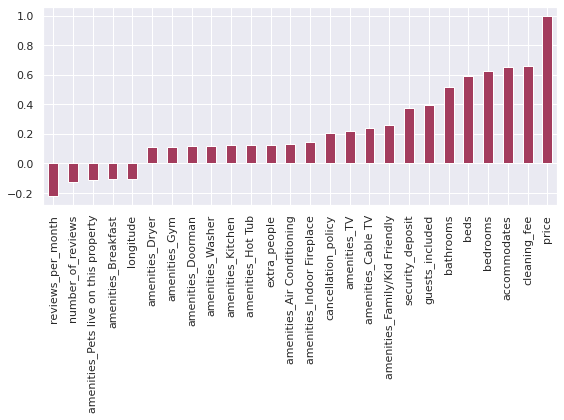

In [6]:
# Main correlations for the price
price_feature = 'price'
sensitivity = 0.1
corr_price = listings_corr[price_feature].loc[listings_corr[price_feature].abs()>sensitivity].drop(['weekly_price','monthly_price'], axis=0)


#### Colors:    '#A33C5D' 'berry' - correlations
####            '#7AA354' 'grass' - details
####            '#B9F071' 'pear'
####            '#34A37F' 'teal'
####            '#41F0B6' 'op'
#    
fig, ax = plt.subplots(figsize=(8,6))
corr_price.sort_values().plot(kind='bar', ax=ax, color='#A33C5D')
#ax.set_title('Overview: Price Correlations', fontdict={'fontsize': 15})
fig.tight_layout()
fig.savefig('price_correlations.png')

<AxesSubplot:>

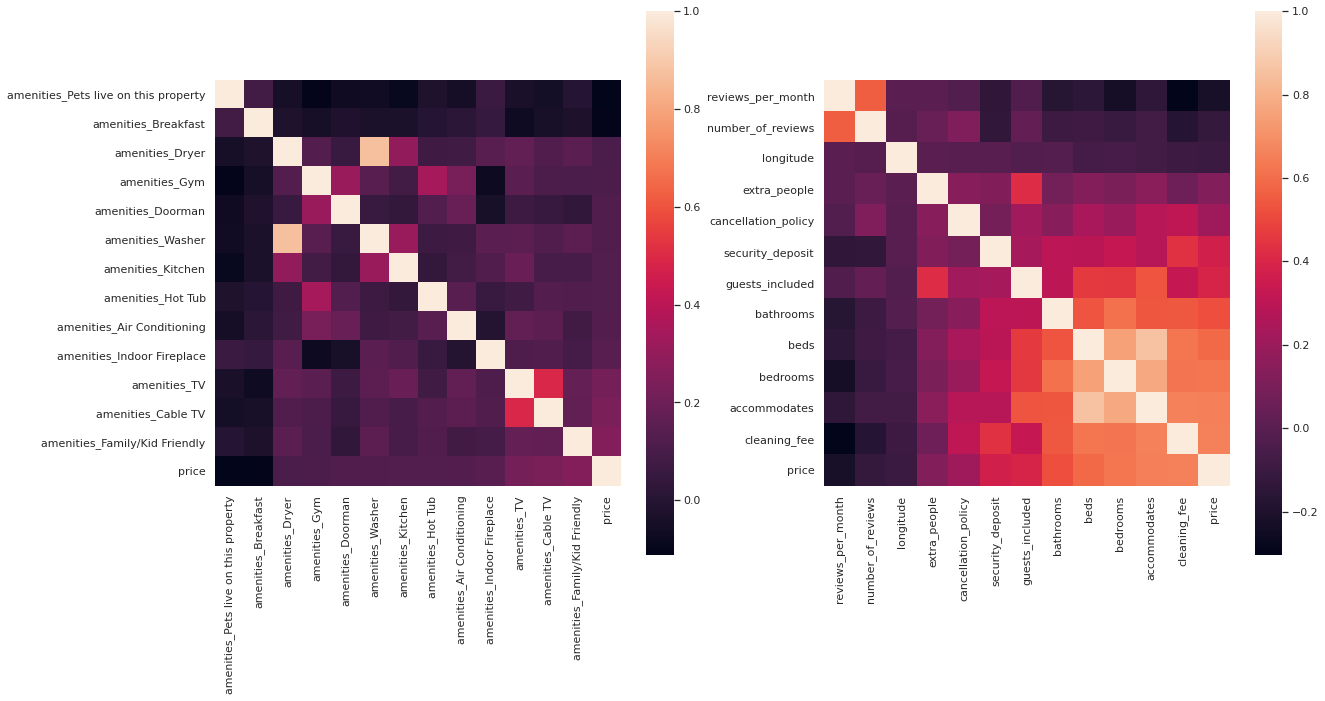

In [7]:
# Sort correlating features into two groups
price_corr_amenities = index_by_key( corr_price, ['amenities', 'price'], False)
price_corr_rest = corr_price.index.difference(price_corr_amenities)

# Visualize the correlations inside the groups
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Amenities correlation matrix
sns.heatmap(listings_drop_trans[price_corr_amenities].corr().sort_values(price_feature).sort_values(price_feature, axis=1), linewidths=0, annot=False, square=True,  ax=ax1)
# Everything else from the main correlations
sns.heatmap(listings_drop_trans[list(price_corr_rest)+['price']].corr().sort_values(price_feature).sort_values(price_feature, axis=1), linewidths=0, annot=False, square=True,  ax=ax2)

* Fist thing to notice is: The price correlates strongly with related fees like cleaning_fee, guests_included,  and security_deposit.
* A second strong relation comes with the number of bedrooms, beds, bathrooms - features which state something about the size and status of the property.
* The plotted correlations between all property and price related features. One can see that in the color pattern of the right grit.
* The number of people a property accommodates also scales with the price.
* Many amenities correlate or anti-correlate with the price. The top ones: Family/Kid Friendly, cable-TV and TV, Indoor Fireplace and Air Conditioning.<br>
    Amenities also correlate among each other.
* The price is negatively correlated with the number of reviews and the reviews per month.
This seems interesting but hard to interpret since it is not 100% clear what the number of reviews represents.
Does a high number of reviews mean, that the property is popular and very often booked?
Does it mean the property has a lot of fluctuation in comparison to properties where people stay for longer intervals?
Does it mean that at this property people tend to write reviews and at other properties people don't?<br>
We can not answer these questions based on the given data-set.



## 2. How Can a Host Improve a Properties Price and Value?
Correlations for the price show high values for room counts and the number of people accommodated.<br>
That makes sens. But it is not entirely within the power of a host to change the number of bedrooms or bathrooms of a property.<br>
Maybe the price can be scaled according to the properties size to make it more comparable.<br>


The plot below shows the influence between *bedrooms* *accommodates* and *price*.<br>
There is an obvious relationship between the number of people who can stay at a property and the number of bedrooms offered.<br>
The price also seems to increase with these two parameters, but not strictly. It is not obvious which parameter is better suited to scale the price.

**Lets try the two new different price-features**: *bedroom_price* and *head_price*<br>

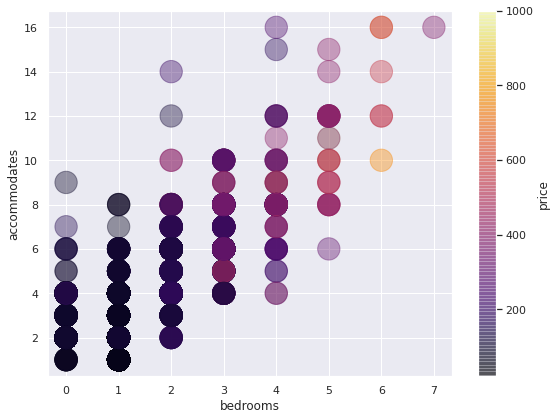

In [8]:
# A scatter-plot for accommodates and bedrooms
fig, ax = plt.subplots(figsize=(8,6))


listings_drop_trans.plot(
    kind="scatter", x="bedrooms",
    y="accommodates", c="price", s=500,
    legend= True, colormap= 'inferno',  alpha=0.4, ax=ax)  

fig.tight_layout()
fig.savefig('accomodates_bedrooms.png')

In [9]:
# New price features: Price per bedroom and price per person
listings_drop_trans['bedroom_price'] = listings_drop_trans['price']/listings_drop_trans['bedrooms'].apply(lambda x: 1 if x==0 else x)
listings_drop_trans['head_price'] = listings_drop_trans['price']/listings_drop_trans['accommodates']

# Remove the weekly and monthly price to focus on the dayly price.
# But keep the information that they were offered.
listings_drop_trans['has_weekly_price'] = listings_drop_trans['weekly_price'].notnull().astype('int')
listings_drop_trans['has_monthly_price'] = listings_drop_trans['monthly_price'].notnull().astype('int')
listings_drop_trans = listings_drop_trans.drop(columns=['monthly_price','weekly_price'], axis=1)

# Update the correlation matrix
listings_corr = listings_drop_trans.corr()

The box-plot below shows a significant difference between the bedroom_price and head_price.<br>
Both are less smeared than the price but bedroom_price hast more outliers than head_price.<br>
The following comparison in correlations goes into detail about the differences.

<AxesSubplot:>

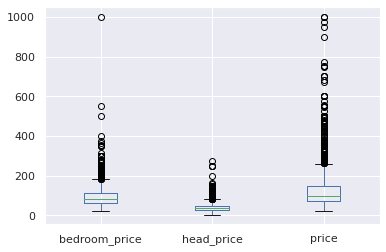

In [10]:
# Compare new price-features distributions with the price in box-plot
listings_drop_trans[['bedroom_price', 'head_price', 'price']].plot(kind='box')

<AxesSubplot:>

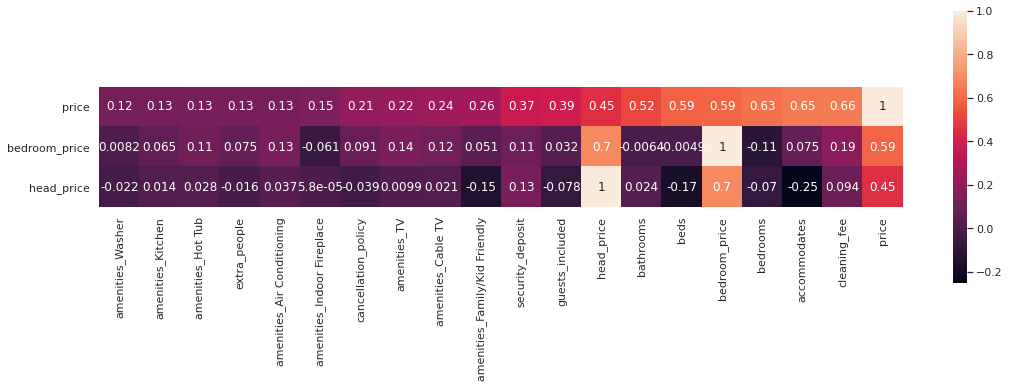

In [11]:
# Compare correlations for different price features:
f, ax = plt.subplots(figsize=(18, 5))

attributes = listings_corr['price'].nlargest(20).index
columns = ['price', 'bedroom_price', 'head_price']
price_corr = listings_corr.loc[attributes, columns].sort_values('price').T

sns.heatmap(price_corr, linewidths=0, annot=True, square=True,  ax=ax)

The Correlations show that *bedroom_price* is probably the best suited measure.<br>
It keeps some correlation with features a host can actually influence and have a certain *hotel-character*.<br>
Whereas the head-price is even anit-correlated with Family Friendly.

**Lets look at the bedroom_price in detail:**
* It has correlations with a group of *amenities*
* Some *review_scores* correlate with the bedroom_price
* And some general attributes are in the set too

This time the sensitivity to choose interesting correlations is set a bit lower to get a larger picture.

In [12]:
#### Colors:    '#A33C5D' 'berry' - correlations
####            '#D4724C' 'brick' - details
####            '#DE6050' 'orange'
####            '#C75269' 'lipstick'
color_1 = '#A33C5D'
color_2 = '#C75269'
color_3 = '#D4724C'
color_4 = '#DE6050'

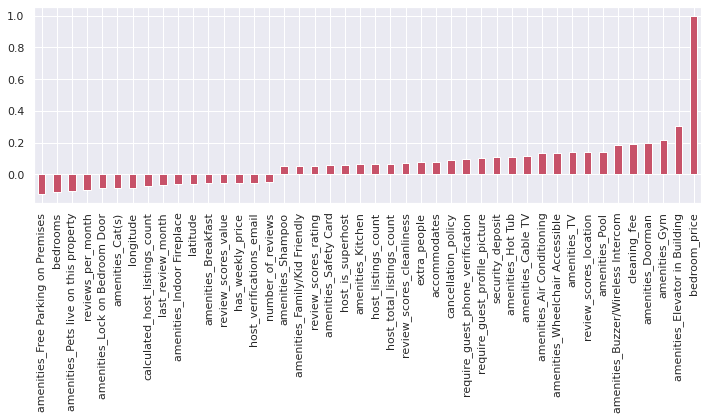

In [13]:
# Isolate the main correlations for the bedroom_price
price_feature = 'bedroom_price'
sensitivity = 0.05
corr_price = listings_corr[price_feature].loc[listings_corr[price_feature].abs()>sensitivity].drop(['head_price', 'price'])

  
fig, ax = plt.subplots(figsize=(6,8))
corr_price.sort_values().plot(kind='bar', figsize=(10,6), ax=ax, color=color_2)
#ax.set_title('Correlations: Price per Bedroom', fontdict={'fontsize': 15})
fig.tight_layout()
fig.savefig('bedroom_price_correlations.png')


In [14]:
# Sort correlating features into groups
price_corr_reviews = index_by_key( corr_price, ['review', 'price'], False)
price_corr_amenities = index_by_key( corr_price, ['amenities', 'price'], False)
price_corr_rest = corr_price.index.difference(price_corr_reviews).difference(price_corr_amenities)

<AxesSubplot:>

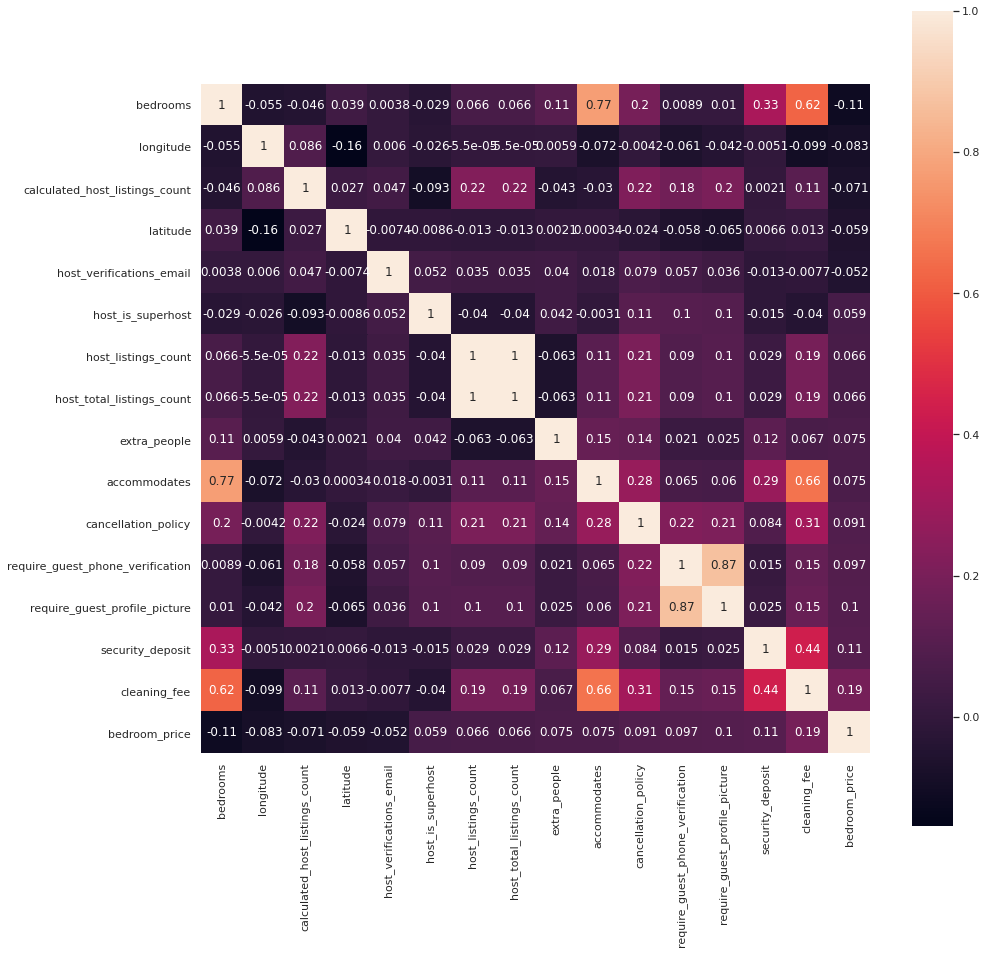

In [15]:
# Plot the correlations for everything exept amenites and review-featurs
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(listings_drop_trans[list(price_corr_rest)+['bedroom_price']].corr().sort_values(price_feature).sort_values(price_feature, axis=1), linewidths=0, annot=True, square=True,  ax=ax)


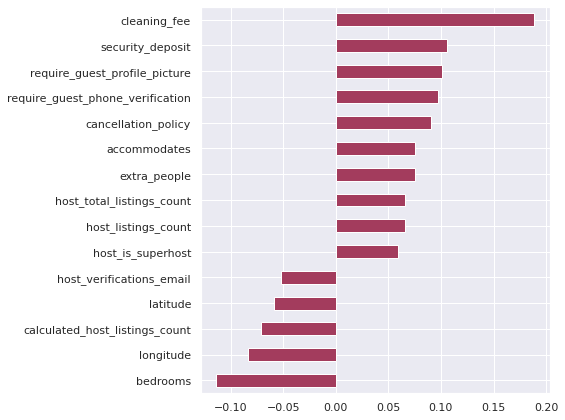

In [16]:
f, ax = plt.subplots(figsize=(8,6))


corr_price[price_corr_rest].sort_values().plot(kind='barh', ax=ax, color=color_1)
f.tight_layout()
f.savefig('corrgeneral_extract.png')

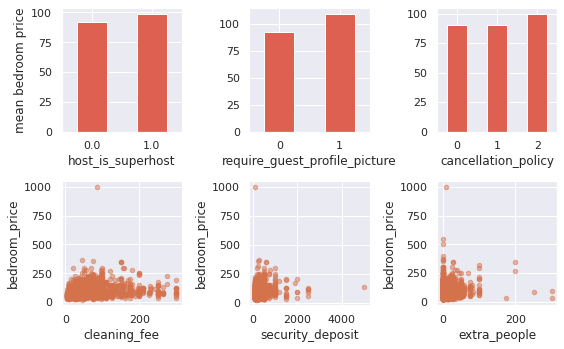

In [17]:
# 'cornflowerblue' 'slateblue' 'bc3754'  'coral'
f, ax = plt.subplots(2, 3, figsize=(8,5))
sort_mean(listings_drop_trans, 'host_is_superhost', 'bedroom_price', True).plot(kind='bar', ax=ax[0,0], ylabel='mean bedroom price', rot=0, legend=False, color=color_4)
sort_mean(listings_drop_trans, 'require_guest_profile_picture', 'bedroom_price', True).plot(kind='bar', ax=ax[0,1], rot=0, legend=False, color=color_4)
sort_mean(listings_drop_trans, 'cancellation_policy', 'bedroom_price', True).plot(kind='bar', ax=ax[0,2], rot=0, legend=False, color=color_4)
listings_drop_trans[['cleaning_fee', 'bedroom_price']].plot(kind='scatter', x='cleaning_fee', y='bedroom_price',ax=ax[1,0], legend=False, color=color_3, alpha = 0.5)
listings_drop_trans[['security_deposit', 'bedroom_price']].plot(kind='scatter', x='security_deposit', y='bedroom_price',ax=ax[1,1], legend=False, color=color_3, alpha = 0.5)
listings_drop_trans[['extra_people', 'bedroom_price']].plot(kind='scatter', x='extra_people', y='bedroom_price',ax=ax[1,2], color=color_3, alpha = 0.5)

f.tight_layout()
f.savefig('non_amenities_or_ratings.png')

**The host characteristics:**
It seems that the experienced host can set the price a little higher.<br>
One can see that in the price margin between *host* and *super_host*.<br>
The total listings count of a host does not display a developement from low to high prices.<br>
It rather seems, that for host with many properties the price fluctuats more and reaches more extream values.<br>
But this is probably caused by a much lower number of hosts with more than 13 properties in the data set.

**Requirements and Conditions:**
Both a strict cancellation policy and a required gueast profile picture increase the price.<br>
We can not test this theory here, but it seems suspicious.<br>
Both seem to be charateristics that are rather caused by a high valued property than increase the value.

<AxesSubplot:ylabel='security_deposit'>

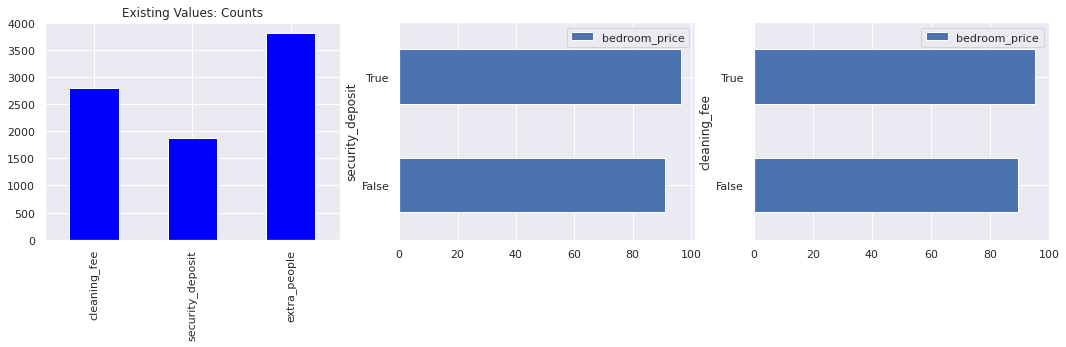

In [28]:
# Check for null-values in the correlating currency columns
df_nullfees = listings_drop_trans[['cleaning_fee', 'security_deposit', 'extra_people']].notnull()
df_price_nullfee = df_nullfees.join(listings_drop_trans['bedroom_price'])

# Plot the the price with and without fees
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
df_nullfees.sum().plot(kind='bar', ax=ax1, title='Existing Values: Counts', color= 'blue')
sort_mean(df_price_nullfee, 'cleaning_fee', 'bedroom_price', True ).plot(kind='barh', ax=ax3)
sort_mean(df_price_nullfee, 'security_deposit', 'bedroom_price', True ).plot(kind='barh', ax=ax2)


**Fees**: Much like requirements and condictions, fees also seem to be something caused by a high valued offer and not the other way around.<br>
Nevertheless fees appear and increase together with a rising bedroom_price.

<AxesSubplot:>

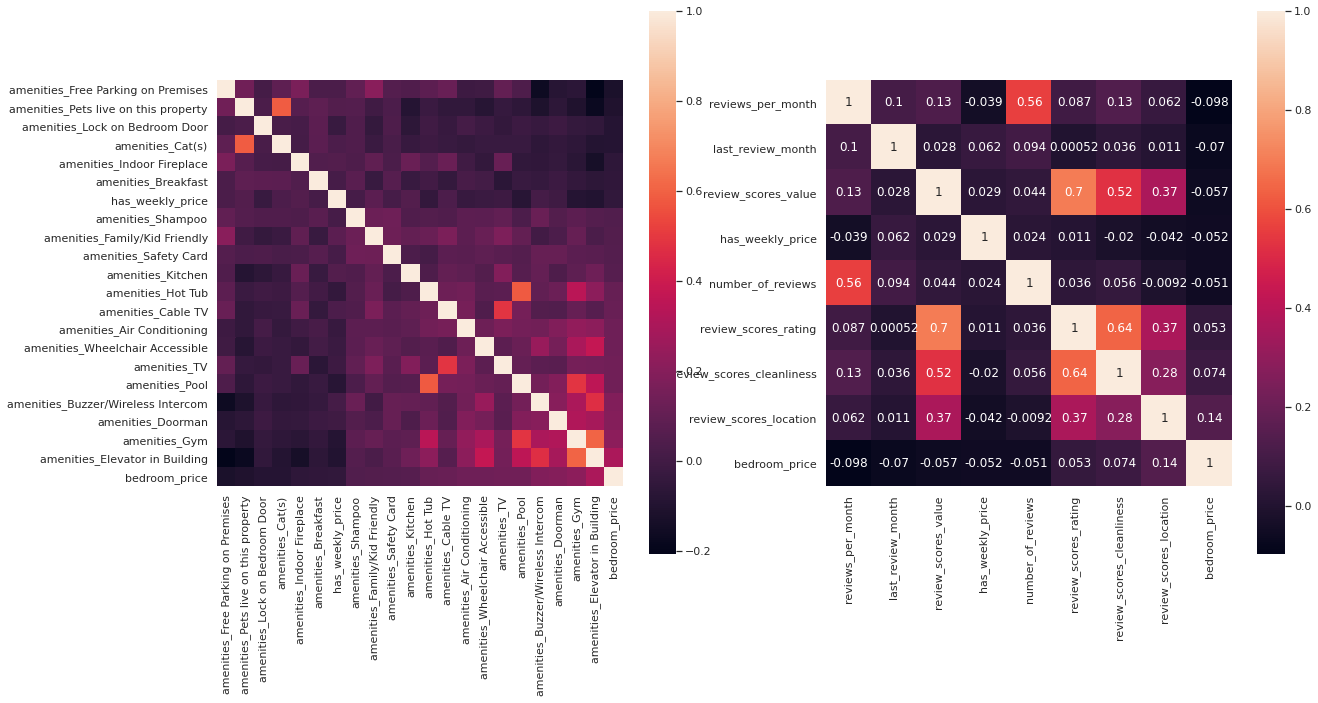

In [20]:
# Plot the correlation matrix for amenities an reviews
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.heatmap(listings_drop_trans[price_corr_amenities].corr().sort_values(price_feature).sort_values(price_feature, axis=1), linewidths=0, annot=False, square=True,  ax=ax1)
sns.heatmap(listings_drop_trans[price_corr_reviews].corr().sort_values(price_feature).sort_values(price_feature, axis=1), linewidths=0, annot=True, square=True,  ax=ax2)

### 2.1 Can a Host Improve His/Her Offer By Supplying Certain Amenities?

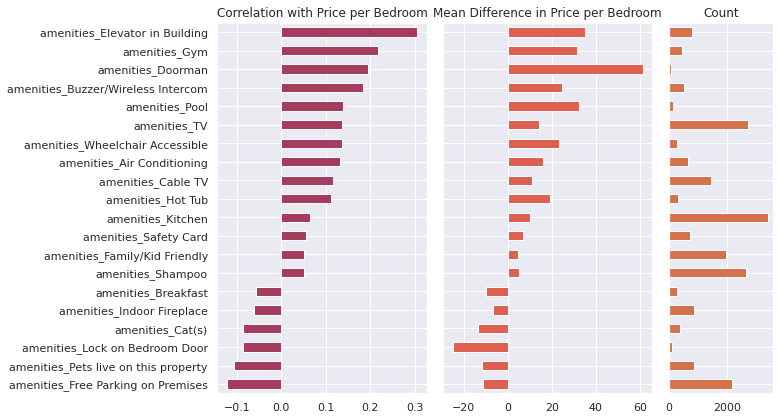

In [21]:
# Amenities above the sensitivity threshold
amenity_names = index_by_key( corr_price, ['amenities'], False)  
# How often are they offered?
amenity_counts = listings_drop_trans[amenity_names].sum()

# Find the mean bedroom_price with and without each amenity
difference_amenities = pd.DataFrame([], columns= [], index=[0,1])
for a in amenity_names:
    mean = sort_mean(listings_drop_trans, a, 'bedroom_price', True)
    difference_amenities[a] = mean['bedroom_price']
difference_amenities = difference_amenities.T

# Calculate the mean price difference for each amenity
difference_amenities['delta'] = difference_amenities[1] - difference_amenities[0]
# Add the counts of each amenity in the data set to the data frame
difference_amenities['count'] = amenity_counts
# Add the bedroom_price correlation of each amenity in the data set to the data frame
difference_amenities['corr'] = listings_corr.loc[amenity_names, 'bedroom_price']

# Plot difference an count for each amenity
difference_amenities = difference_amenities.sort_values('corr')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,6), sharey = True, gridspec_kw={'width_ratios': [2, 2, 1]})
difference_amenities['count'].plot(kind='barh', ax=ax3, title= 'Count', color=color_3 )
difference_amenities['delta'].plot(kind='barh', ax=ax2, title= 'Mean Difference in Price per Bedroom', color=color_4)
difference_amenities['corr'].plot(kind='barh', ax=ax1, title= 'Correlation with Price per Bedroom', color=color_1)
f.tight_layout()
f.savefig('amenities.png')


**The Offer:**
It seems that certain amenities make a big difference in the price.
Not all of them seem to appear often, which makes the statistics hard to interprete. A Doorman seems to come with a very high price but there are also very few properties wich actualy have one. It is hard to say then, wether this is a generall correlation or an outlyer.<br>

Amenities improving the price and having more than 500 counts:<br>

* Safety Card
* Family Friendlyness
* TV and Cable TV
* Buzzer/Intercom

Amenities improving the price which take a little more investment:<br>

* Elevator
* Air conditioning
* A kitchen
* A hot tub
* Weelchair accessibility

### 2.2 How Does The Price Play Together with Guest-Reviews?

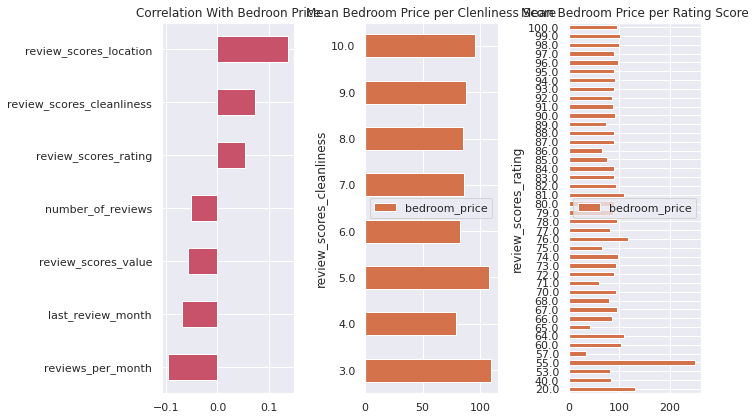

In [23]:
# Idendify review-featurs with price-correlation
review_names = index_by_key( corr_price, ['review'], False)
# Count listings per review scores
rating_counts = listings_drop_trans[['bedroom_price']].groupby(listings_drop_trans['review_scores_rating']).count()
cleanliness_counts = listings_drop_trans[['bedroom_price']].groupby(listings_drop_trans['review_scores_cleanliness']).count()


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
listings_corr.loc[review_names, 'bedroom_price'].sort_values().plot(kind='barh', ax=ax1, title='Correlation With Bedroon Price', color=color_2)
sort_mean(listings_drop_trans, 'review_scores_cleanliness', 'bedroom_price', True).plot(kind='barh', ax=ax2, title= 'Mean Bedroom Price per Clenliness Score', color=color_3)
sort_mean(listings_drop_trans, 'review_scores_rating', 'bedroom_price', True).plot(kind='barh', ax=ax3, title='Mean Bedroom Price per Rating Score', color=color_3)
#rating_counts.plot(kind='barh', ax=ax4, title='Rating Counts', legend=False)
#cleanliness_counts.plot(kind='barh', ax=ax5, title='Cleanliness Score Counts', legend=False)
f.tight_layout()


**Reputation:**The most interesting correlations are the cleanliness scores and ratings.<br>
The histograms for both show that the distributions are scewed to high values (positiv evaluations).
Considering that, it is no surprise, the mean bedroom price per score is smoother for higher values. <br>
Unfortunately that makes it hard to see the correlation in the figure above due to fluctuations in lower regions.<br>
**But the scatter plots below definatly show a tendency for high priced properties to have higher scores.**

<ipython-input-24-42e6d51ae57e>:15: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


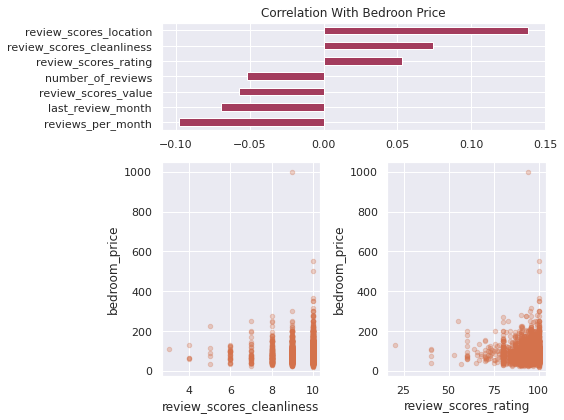

In [24]:
# Create objects
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 2])
  
# Create sub plots as grid
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


# Scatter plots:
listings_drop_trans.plot(kind='scatter', x='review_scores_cleanliness', y='bedroom_price', alpha=0.3, ax=ax2, color=color_3)
listings_drop_trans.plot(kind='scatter', x='review_scores_rating', y='bedroom_price', alpha=0.3, ax=ax3, color=color_3)
listings_corr.loc[review_names, 'bedroom_price'].sort_values().plot(kind='barh', title='Correlation With Bedroon Price', ax=ax1, color=color_1)
fig.tight_layout()
fig.savefig('review_scores.png')

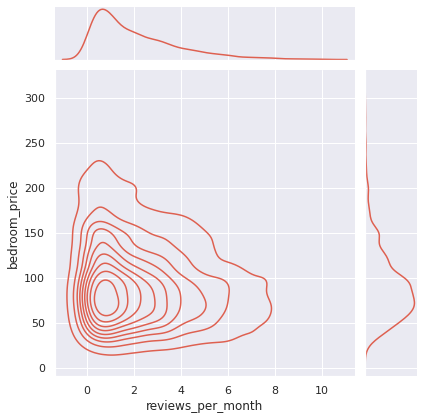

In [25]:
# Bedroom_price is anti-correlated to reviews per month: Displat the relation between both features
# Restrict the df to the relevant plotting range
df_review_plott = listings_drop_trans[price_corr_reviews].loc[listings_drop_trans['bedroom_price']<300].loc[listings_drop_trans['reviews_per_month']<=10]
# Plot

f = sns.jointplot(x=df_review_plott['reviews_per_month'], y=df_review_plott['bedroom_price'],  kind="kde", color = color_4, ax=ax)
plt.savefig('reviews_per_month.png')


### 0. Other Influences On The Price
There are definately more paramteres influencing the price. But we are intereste in those a Host might try tu influence.<br>
The review correlations already showed, the location scores have a higher correlation than the review or cleanliness scores. But a host can not do much about the properties location.<br>
**Below are some exemples for what else influences the price.**

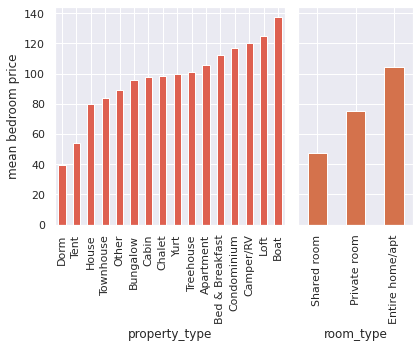

In [26]:
# Calculate the mean 'bedroom_price' for room types and property types
property_to_price = sort_mean(listings_drop_trans, 'property_type', 'bedroom_price')
room_to_price = sort_mean(listings_drop_trans, 'room_type', 'bedroom_price')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,5), sharey=True, gridspec_kw={'width_ratios':[2,1]})

property_to_price.plot(kind='bar', ax=ax1, color=color_4, legend=False, ylabel='mean bedroom price')
room_to_price.plot(kind='bar', ax=ax2, color=color_3, legend=False)
f.tight_layout()
f.savefig('property.png')

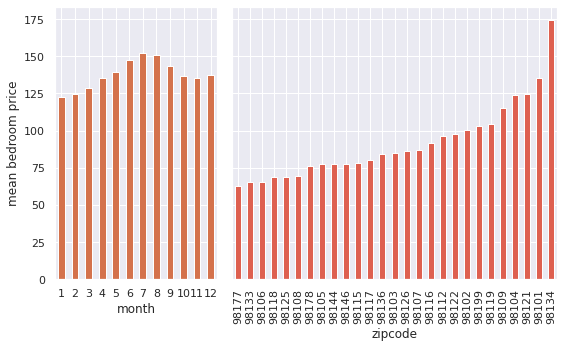

In [27]:
df_calendar = pd.read_csv('./data/calendar.csv')
# price is a string type: convert to a float
df_calendar['price'] = df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
# transformnig the data calumns in df_calendar to date-type
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
# split the date information into three columns
df_calendar["day"] = df_calendar['date'].map(lambda x: x.day)
df_calendar["month"] = df_calendar['date'].map(lambda x: x.month)
df_calendar["year"] = df_calendar['date'].map(lambda x: x.year)

# Calculate the mean price per month (in 2016)
price_month = sort_mean(df_calendar, 'month', 'price').sort_index()
# Calculate mean prices per zipcode
listings_drop_trans.loc[listings_drop_trans['zipcode']== '99\n98122', 'zipcode'] = '98122'
zipcode_to_price = sort_mean(listings_drop_trans, 'zipcode', 'bedroom_price')

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), sharey=True, gridspec_kw={'width_ratios': [1,2]})
price_month.plot(kind="bar", ax=ax1, color=color_3, rot=0, ylabel='mean bedroom price', legend=False)
zipcode_to_price.plot(kind='bar', ax=ax2, color=color_4, legend=False)
f.tight_layout()
f.savefig('zipcode_month.png')